# Load library and bitstream
need to run in any cases

In [1]:
import cv2
import torch
from torch import tensor
import time, os
import numpy as np
import matplotlib.pyplot as plt
from pynq_dpu import DpuOverlay
import pynq
from pynq import Overlay

In [3]:
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu.xmodel")

In [4]:
overlay.ip_dict

{'axi_gpio_0': {'type': 'xilinx.com:ip:axi_gpio:2.0',
  'mem_id': 'S_AXI',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_FAMILY': 'zynquplus',
   'C_S_AXI_ADDR_WIDTH': '9',
   'C_S_AXI_DATA_WIDTH': '32',
   'C_GPIO_WIDTH': '2',
   'C_GPIO2_WIDTH': '32',
   'C_ALL_INPUTS': '0',
   'C_ALL_INPUTS_2': '0',
   'C_ALL_OUTPUTS': '1',
   'C_ALL_OUTPUTS_2': '0',
   'C_INTERRUPT_PRESENT': '0',
   'C_DOUT_DEFAULT': '0x00000000',
   'C_TRI_DEFAULT': '0xFFFFFFFF',
   'C_IS_DUAL': '0',
   'C_DOUT_DEFAULT_2': '0x00000000',
   'C_TRI_DEFAULT_2': '0xFFFFFFFF',
   'Component_Name': 'base_axi_gpio_0_1',
   'USE_BOARD_FLOW': 'false',
   'GPIO_BOARD_INTERFACE': 'Custom',
   'GPIO2_BOARD_INTERFACE': 'Custom',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_BASEADDR': '0x80000000',
   'C_HIGHADDR': '0x8000FFFF',
   'DATA_WIDTH': '32',
   'PROTOCOL': 'AXI4LITE',
   'FREQ_HZ': '99999001',
   'ID_WIDTH': '0',
   'ADDR_WIDTH': '9',
   'AWUSER_WIDTH': '0',
   'ARUSER_WIDTH': '0',
   'WUSER_W

In [5]:
timer = overlay.axi_timer_0
gpio = overlay.axi_gpio_0

# SERVO PWM CONTROL


In [4]:
MASK_MDT = 0 # TCSR 0
MASK_UDT = 1 # TCSR 1
MASK_GENT = 2 # TCSR 1
MASK_LOAD = 5 # TCSR 1
MASK_ENT = 7
MASK_INT = 8
MASK_PWM = 9 # TCSR 1
MASK_ENALL = 10
REG_TCSR0 = 0x0
REG_TCSR1 = 0x10
REG_TLR0 = 0x4
REG_TLR1 = 0x14

CONFIG = (
    (MASK_MDT, 0),
    (MASK_PWM, 1),
    (MASK_GENT, 1),
    (MASK_UDT, 1),
    (MASK_INT, 1)
)



def write_reg_bit(ip, reg, bit, value):
    v = ip.read(reg)
    v = ((v & ~(1 << bit)) | ((value & 0x1) << bit))
    ip.write(reg, v)
    
def set_pwm(high_period, period=5): # in ms
    load0 = int(period * 1000 * 1000 // 10 - 2)
    load1 = int(high_period * 1000 * 1000 // 10 - 2)
    timer.write(REG_TLR0, load0)
    timer.write(REG_TLR1, load1)
    
def set_angle(angle, min_time = 0.5, max_time = 2.5, min_angle = 0, max_angle = 270):
    if angle < min_angle or angle > max_angle:
        raise ValueError("Invalid input angle")
    ratio = (angle - min_angle) / (max_angle - min_angle)
    period = ratio * (max_time - min_time) + min_time
    set_pwm(period)

# load config
for reg in [REG_TCSR0, REG_TCSR1]:
    for bit, value in CONFIG:
        write_reg_bit(timer, reg, bit, value)

# set pwm
# set_pwm(2, 5)
set_angle(180)

#start
write_reg_bit(timer, REG_TCSR0, MASK_ENALL, 1)


In [19]:
# PWM usage example

while(True):
    for i in np.array(range(0, 270)):
        set_angle(i)
        time.sleep(0.05)
    for i in np.array(range(270, 0, -1)):
        set_angle(i)
        time.sleep(0.05)

KeyboardInterrupt: 

# DC MOTOR LIBRARY

In [6]:
# DC motor library
GPIO_TURN = 0
GPIO_REVERSE = 1
GPIO_STOP = 2
# NOW only support GPIO_TURN and GPIO_STOP
def set_gpio(status):
    if status == GPIO_TURN:
        gpio.channel1.write(1, 0x3)
    elif status == GPIO_REVERSE:
        gpio.channel1.write(2, 0x3)
    elif status == GPIO_STOP:
        gpio.channel1.write(0,0x03)


In [18]:
# GPIO usage example

while(True):
    set_gpio(GPIO_TURN)
    time.sleep(0.05)
    set_gpio(GPIO_STOP)
    time.sleep(0.05)
    set_gpio(GPIO_REVERSE)
    time.sleep(0.05)
    set_gpio(GPIO_STOP)
    time.sleep(0.05)

KeyboardInterrupt: 

# DPU runtime and yolov5 preprocess & postprocess

In [6]:
CLASS_NAME = ['Early-Turning', 'Green', 'Late-Turning', 'Red', 'Turning', 'White']
device = torch.device("cpu")

def resize_and_pad(image, output_size=(640, 640), pad_color=(128, 128, 128)):

    # 获取图像尺寸
    h, w = image.shape[:2]

    # 计算比例
    scale = min(output_size[0] / w, output_size[1] / h)

    # 计算新的尺寸
    new_w = int(w * scale)
    new_h = int(h * scale)

    # 调整图像大小
    resized_image = cv2.resize(image, (new_w, new_h))

    # 创建带背景色的新的图像
    new_image = np.full((output_size[1], output_size[0], 3), pad_color, dtype=np.uint8)

    # 将调整大小后的图像放到中心
    x_offset = (output_size[0] - new_w) // 2
    y_offset = (output_size[1] - new_h) // 2
    new_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_image

    return new_image

class Parameter:
    def __init__(self):
        self.nc = 6
        self.no = 11
        self.nl = 3
        self.na = 3
        self.grid = [tensor([], device=device), tensor([], device=device), tensor([], device=device)]
        self.anchor_grid = [tensor([]), tensor([]), tensor([])]
        self.anchors = torch.tensor([[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], device=device) / 32
        self.anchors = self.anchors.float().view(3,-1,2)
        self.stride = tensor([ 8., 16., 32.], device=device)

        self.conf_thres=0.25  # confidence threshold
        self.iou_thres=0.45  # NMS IOU threshold
        self.classes=None  # filter by class: --class 0, or --class 0 2 3
        self.agnostic_nms=False  # class-agnostic NMS
        self.max_det=1000
        
param = Parameter()

def xywh2xyxy(x):
    """Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right."""
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

def box_iou(box1, box2, eps=1e-7):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.

    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

def postprocess(x):

    def _make_grid(nx=20, ny=20, i=0):
        """Generates a mesh grid for anchor boxes with optional compatibility for torch versions < 1.10."""
        d = device
        t = torch.float32
        shape = 1, param.na, ny, nx, 2  # grid shape
        y, x = torch.arange(ny, device=d, dtype=t), torch.arange(nx, device=d, dtype=t)
        yv, xv = torch.meshgrid(y, x, indexing="ij")  # torch>=0.7 compatibility
        grid = torch.stack((xv, yv), 2).expand(shape) - 0.5  # add grid offset, i.e. y = 2.0 * x - 0.5
        anchor_grid = (param.anchors[i] * param.stride[i]).view((1, param.na, 1, 1, 2)).expand(shape)
        return grid, anchor_grid

    for i in range(param.nl):
        z = []
        bs, _, ny, nx = x[i].shape  # x(bs,255,20,20) to x(bs,3,20,20,85)
        x[i] = x[i].view(bs, param.na, param.no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()
        param.grid[i], param.anchor_grid[i] = _make_grid(nx, ny, i)
        xy, wh, conf = x[i].sigmoid().split((2, 2, param.nc + 1), 4)
        xy = (xy * 2 + param.grid[i]) * param.stride[i]  # xy
        wh = (wh * 2) ** 2 * param.anchor_grid[i]  # wh
        y = torch.cat((xy, wh, conf), 4)
        z.append(y.view(bs, param.na * nx * ny, param.no))
    return torch.cat(z, 1), x

def nms(boxes, scores, iou_threshold):
    """
    Perform non-maximum suppression (NMS) on the boxes based on their scores.

    Args:
        boxes (Tensor[N, 4]): boxes to perform NMS on. They are expected to be in (x1, y1, x2, y2) format.
        scores (Tensor[N]): scores for each one of the boxes.
        iou_threshold (float): discards all overlapping boxes with IoU > iou_threshold

    Returns:
        keep (Tensor): int64 tensor with the indices of the elements that have been kept by NMS, sorted in decreasing order of scores.
    """
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.int64, device=boxes.device)
    
    # Compute the areas of the boxes
    x1, y1, x2, y2 = boxes.unbind(1)
    areas = (x2 - x1) * (y2 - y1)
    
    # Sort the boxes by scores in descending order
    _, order = scores.sort(0, descending=True)
    
    keep = []
    while order.numel() > 0:
        if order.numel() == 1:
            break
        i = order[0].item()
        keep.append(i)
        
        xx1 = torch.max(x1[i], x1[order[1:]])
        yy1 = torch.max(y1[i], y1[order[1:]])
        xx2 = torch.min(x2[i], x2[order[1:]])
        yy2 = torch.min(y2[i], y2[order[1:]])
        
        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h
        
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        
        inds = (iou <= iou_threshold).nonzero(as_tuple=False).squeeze()
        if inds.numel() == 0:
            break
        order = order[inds + 1]
    
    return torch.tensor(keep, dtype=torch.int64, device=boxes.device)

def non_max_suppression(
    prediction,
    conf_thres=0.25,
    iou_thres=0.45,
    classes=None,
    agnostic=False,
    multi_label=False,
    labels=(),
    max_det=300,
    nm=0,  # number of masks
):
    """
    Non-Maximum Suppression (NMS) on inference results to reject overlapping detections.

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    # Checks
    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
    if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    device = prediction.device
    mps = "mps" in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.5 + 0.05 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    mi = 5 + nc  # mask start index
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box/Mask
        box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = x[:, 5:mi].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3e3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            print("Warning: excceed time")
            break  # time limit exceeded

    return output

def draw_boxes(img, boxes, class_names=CLASS_NAME):
    """
    Draw bounding boxes with labels on an image.
    
    Args:
        img (numpy.ndarray): The image on which to draw.
        boxes (list of lists): Each box is a list in the format [x0, y0, x1, y1, conf, class].
        class_names (list of str): List of class names indexed by class id.
        
    Returns:
        img (numpy.ndarray): The image with bounding boxes and labels drawn.
    """
    for box in boxes:
        x0, y0, x1, y1, conf, cls_id = list(box)
        cls_id = int(cls_id)
        
        # Draw the bounding box
        color = (0, 255, 0)  # Green color for bounding box
        cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)), color, 2)
        
        # Draw the label
        label = f"{class_names[cls_id]}: {conf:.2f}"
        (label_width, label_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(img, (int(x0), int(y0) - label_height - baseline), (int(x0) + label_width, int(y0)), color, cv2.FILLED)
        cv2.putText(img, label, (int(x0), int(y0) - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    
    return img

In [7]:
# dpu runtime object
# must run before use of dpu
dpu = overlay.runner
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()
shapeIn = tuple(inputTensors[0].dims)
shapeOut0 = (tuple(outputTensors[0].dims)) # (1, 80, 80, 33)
shapeOut1 = (tuple(outputTensors[1].dims)) # (1, 40, 40, 33)
shapeOut2 = (tuple(outputTensors[2].dims)) # (1, 20, 20, 33)

outputSize0 = int(outputTensors[0].get_data_size() / shapeIn[0]) # 12675
outputSize1 = int(outputTensors[1].get_data_size() / shapeIn[0]) # 50700
outputSize2 = int(outputTensors[2].get_data_size() / shapeIn[0]) # 202800

# Test camera 

(1, 640, 640, 3)


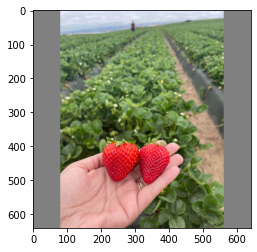

In [9]:
# preprocess of input image
# must run before use
# if fail, check the webcam and rerun this cell

def preprocess(image=None, path = None):
    if image is not None and path is not None:
        raise NotImplementedError()
    if path:
        img = cv2.cvtColor(resize_and_pad(image_path), cv2.COLOR_BGR2RGB)
    else:
        img = resize_and_pad(image)
    
    FIX_POINT = inputTensors[0].get_attr("fix_point")
    FIX_SCALE = 2 ** (8 - FIX_POINT)
    im = img // FIX_SCALE * FIX_SCALE # HWC to CHW, BGR to RGB
    im = np.ascontiguousarray(im)
    imr = im.copy()
    im = torch.tensor(np.array((im, )), dtype=torch.uint8)
    plt.imshow(im.numpy()[0])
    im = im // FIX_SCALE
    return im.numpy()
    
        

image_path = "strawberry-varieties-in-hand.jpg"

cap = cv2.VideoCapture(0)
ret, image = cap.read()
while not ret:
    pass
image = preprocess(image=image)
print(image.shape)
cap.release()

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fpga_in = preprocess(image=img)

# INPUT TENSOR AND OUTPUT TENSOR FORMAT

In [10]:
# load in/out tensor
# must run
input_data = [np.empty(shapeIn, dtype=np.int8, order="C")]
output_data = [np.empty(shapeOut0, dtype=np.int8, order="C"), 
               np.empty(shapeOut1, dtype=np.int8, order="C"),
               np.empty(shapeOut2, dtype=np.int8, order="C")]
image = input_data[0]

In [11]:
# load image input tensor
image_data = fpga_in.copy()
image[0,...] = image_data

In [12]:
t0 = time.time()
job_id = dpu.execute_async(input_data, output_data)
dpu.wait(job_id)
print(1 / (time.time() - t0))

14.24178033119756


In [13]:
output_fixpos = [outputTensors[i].get_attr("fix_point") for i in range(len(outputTensors))]
output_scale = [1 / (2**output_fixpos[i]) for i in range(len(output_fixpos))]
fpga_output = [torch.tensor(output_data[i].copy() * output_scale[i], dtype=torch.float32) for i in range(len(output_scale))]

In [14]:
predi = [i.permute(0, 3, 1, 2) for i in fpga_output]
pred = postprocess(predi)
pred = non_max_suppression(pred[0], param.conf_thres, param.iou_thres, param.classes, param.agnostic_nms, max_det=param.max_det)
img_result = draw_boxes(img, pred[0].cpu().numpy())
print(pred[0])

tensor([[3.1384e+02, 3.9420e+02, 4.0279e+02, 5.0797e+02, 8.2832e-01, 3.0000e+00],
        [2.0955e+02, 3.8828e+02, 3.1152e+02, 5.0206e+02, 8.1138e-01, 3.0000e+00],
        [3.8665e+02, 3.8931e+02, 4.3441e+02, 4.2636e+02, 4.4872e-01, 2.0000e+00],
        [4.0223e+02, 4.1775e+02, 4.4240e+02, 4.6151e+02, 4.4656e-01, 2.0000e+00]])


True

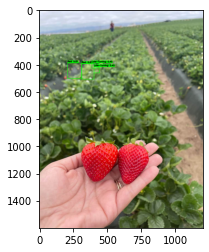

In [15]:
plt.imshow(img_result)
cv2.imwrite("output.jpg", img_result)

In [ ]:
outputTensors[2].get_attrs()

# real-time webcam with DPU

In [21]:
import cv2
import threading
import queue
import time
from matplotlib import pyplot as plt
from IPython.display import display, Image
import ipywidgets as widgets


# 创建一个队列用于线程之间的数据共享
frame_queue = queue.Queue(maxsize=2)
box_queue = queue.Queue(maxsize=2)
image_queue = queue.Queue(maxsize=2)

# 停止标志
stop_flag = False
frame_rect = None
fps = 0
analyzed_frame = None

output = widgets.Output()
display(output)

# 读取图像的线程函数
def capture_frames():
    global stop_flag, fps, cap
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("无法打开摄像头")
        return

    start_time = time.time()
    frame_count = 0

    while not stop_flag:
        ret, frame = cap.read()
        if not ret:
            print("无法读取摄像头帧")
            break

        if not frame_queue.full():
            frame_queue.put((frame, time.time()))
        if not image_queue.full():
            image_queue.put(frame.copy(), time.time())

        frame_count += 1
        if frame_count >= 30:
            end_time = time.time()
            fps = frame_count / (end_time - start_time)
            frame_count = 0
            start_time = end_time
#             print(f"当前帧率: {fps:.2f} FPS")

#         time.sleep(0.1)  # 控制读取帧的速度

    cap.release()
    with output:
        print("capture_frames 线程已停止")
    return

# dpu function
def dpu_scan():
    global frame_rect, stop_flag
    job_id = None
    
    input_data = [np.empty(shapeIn, dtype=np.int8, order="C")]
    output_data = [np.empty(shapeOut0, dtype=np.int8, order="C"), 
               np.empty(shapeOut1, dtype=np.int8, order="C"),
               np.empty(shapeOut2, dtype=np.int8, order="C")]
    image = input_data[0]
    
    while(True):
        if job_id:
            dpu.wait(job_id)
            output_fixpos = [outputTensors[i].get_attr("fix_point") for i in range(len(outputTensors))]
            output_scale = [1 / (2**output_fixpos[i]) for i in range(len(output_fixpos))]
            fpga_output = [torch.tensor(output_data[i].copy() * output_scale[i], dtype=torch.float32) for i in range(len(output_scale))]
            predi = [i.permute(0, 3, 1, 2) for i in fpga_output]
            pred = postprocess(predi)
            pred = non_max_suppression(pred[0], param.conf_thres, param.iou_thres, param.classes, param.agnostic_nms, max_det=param.max_det)
            frame_rect = pred[0].cpu().numpy()
            job_id = None
            if not box_queue.full():
                box_queue.put(frame_rect)
            
        if stop_flag:
            break
        
        if not image_queue.empty():
            frame = image_queue.get()
            fpga_input = preprocess(image=frame)
            image[0,...] = fpga_input.reshape(shapeIn[1:])
            job_id = dpu.execute_async(input_data, output_data)
        
        time.sleep(0.02)
    with output:
        print("DPU线程已结束")

# 停止线程的函数
def stop_threads(*args):
    global stop_flag
    stop_flag = True
    for i in args:
        print(f"Stopping {i}")
        i.join()
    print("所有线程已停止")

Output()

In [22]:
stop_flag = False

# 创建并启动读取图像的线程
capture_thread = threading.Thread(target=capture_frames)
capture_thread.start()

dpu_thread = threading.Thread(target=dpu_scan)
dpu_thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

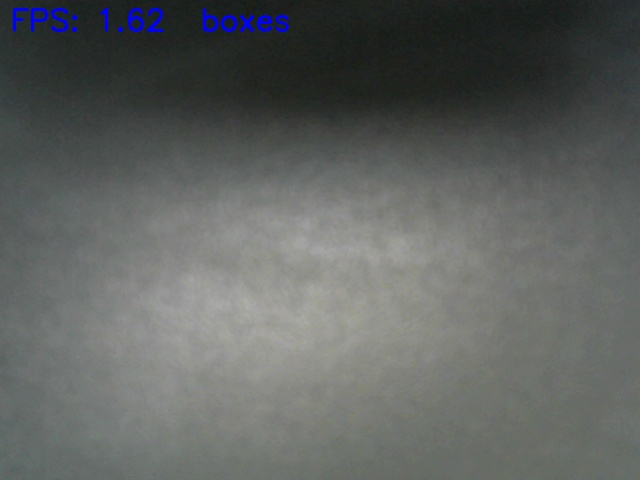

In [23]:
# display image and result

stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view():
    global fps, stop_flag
    display_handle=display(None, display_id=True)
    start_time = 0
    boxes = None
    while(True):
        if not frame_queue.empty():
            frame, _ = frame_queue.get()
            
            if not box_queue.empty():
                boxes = box_queue.get()
                cv2.putText(frame, f"boxes", (200, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            if boxes is not None:
                frame = draw_boxes(frame, boxes)
    
            # 显示帧率
            cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            
            _, frame = cv2.imencode('.jpeg', frame)
            display_handle.update(Image(data=frame.tobytes()))
            if (stopButton.value or stop_flag):
                display_handle.update(None)
                break
    print(1)
    print("显示线程已停止")

#         time.sleep(0.1)  # 控制显示帧的速度
        
display(stopButton)
view_thread = threading.Thread(target=view)
view_thread.start()

In [20]:
# stop all threads
# must call when meet some issue

stop_threads(capture_thread, dpu_thread)


Stopping <Thread(Thread-6 (capture_frames), stopped 281471176339744)>
Stopping <Thread(Thread-7 (dpu_scan), stopped 281471167885600)>
所有线程已停止


In [ ]:
# check thread status

for thread in threading.enumerate(): 
    print(thread.name, thread.is_alive())

In [ ]:
del cap